In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
from timeit import default_timer as timer
def print_train_time(start:float, end : float, device : torch.device = None):
    total_time = end - start
    print(f' Train time :{total_time:.3f}')
    return total_time


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:03<00:00, 49762806.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
# Define ResNet
import torchvision.models as models
model_0 = models.resnet18(pretrained=True)
model_0

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

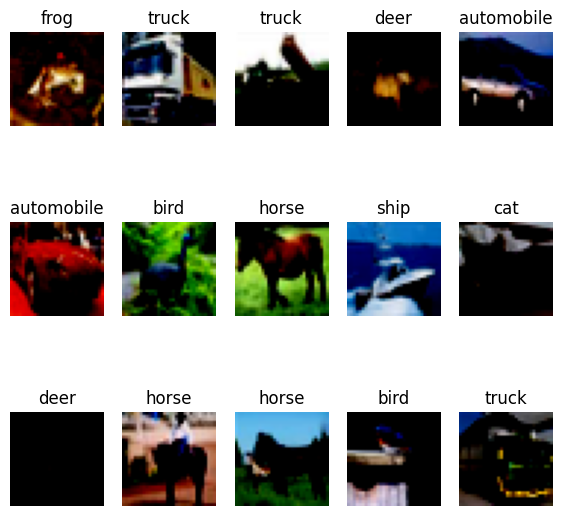

In [8]:
fig = plt.figure(figsize=(7,7))
for j in range(15):
  fig.add_subplot(3, 5, j+1)
  img, label = trainset[j]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(trainset.classes[label])
  plt.axis('off')


In [9]:
img, label = trainset[0]
img.shape, label

(torch.Size([3, 32, 32]), 6)

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
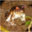

In [10]:
trainset.data[0]

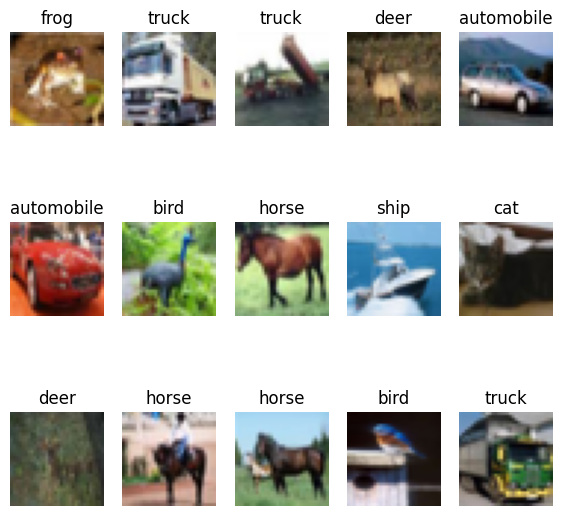

In [11]:
fig = plt.figure(figsize=(7,7))
for j in range(15):
  fig.add_subplot(3, 5, j+1)
  plt.imshow(trainset.data[j])
  plt.title(trainset.classes[trainset.targets[j]])
  plt.axis('off')


In [12]:
import torchsummary

In [13]:
model_0 = model_0.to(device)
torchsummary.summary(model_0, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(), lr=0.001, momentum=0.9)

In [15]:
model_0_train_time_start = timer()
epochs = 15
for epoch in range(epochs):
  model_0.train()
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      model_0 = model_0.to(device)
      outputs = model_0(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

model_0_train_time_end = timer()

Epoch 1, Loss: 1.1815834782936598
Epoch 2, Loss: 0.6970848988071895
Epoch 3, Loss: 0.5504988588378434
Epoch 4, Loss: 0.4487157794989536
Epoch 5, Loss: 0.37201859794857406
Epoch 6, Loss: 0.30666588592657046
Epoch 7, Loss: 0.259150452617501
Epoch 8, Loss: 0.21280907730852575
Epoch 9, Loss: 0.18425193267873824
Epoch 10, Loss: 0.15244673745157297
Epoch 11, Loss: 0.13323777282052815
Epoch 12, Loss: 0.11200402353651004
Epoch 13, Loss: 0.1008938753642845
Epoch 14, Loss: 0.08987619027540669
Epoch 15, Loss: 0.07533939227261309


In [16]:
print_train_time(start=model_0_train_time_start, end= model_0_train_time_end, device= device)

 Train time :477.879


477.87883699099996

In [17]:
model_0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model_0_cuda_evaluation_start = timer()
model_0.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model_0= model_0.to(device)
        outputs = model_0(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
model_0_cuda_evaluation_end = timer()

Accuracy of the network on the 10000 test images: 81 %


In [19]:
print_train_time(start= model_0_cuda_evaluation_start, end= model_0_cuda_evaluation_end, device= device)

 Train time :4.245


4.245307464999996

In [20]:
device = torch.device('cpu')
model_0_cpu_evaluation_start = timer()
model_0.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model_0= model_0.to(device)
        outputs = model_0(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
model_0_cpu_evaluation_end = timer()

Accuracy of the network on the 10000 test images: 81 %


In [21]:
print_train_time(start= model_0_cpu_evaluation_start, end= model_0_cpu_evaluation_end, device= device)

 Train time :27.164


27.16429231999996

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_0 = model_0.to(device)
torchsummary.summary(model_0, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
model_1 = models.resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)
torchsummary.summary(model_1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [26]:
import torch.nn.utils.prune as prune

def prune_model(model, pruning_rate=0.1):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):

            # Applying unstructured L1 norm pruning
            prune.l1_unstructured(module, name='weight', amount=pruning_rate)

            prune.remove(module, 'weight')

In [27]:
model_1_training_start = timer()
for epoch in range(epochs):
    running_loss = 0.0
    model_1.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        model_1 = model_1.to(device)
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

    if (epoch + 1) % 5 == 0:
        print(f'Pruning after epoch {epoch + 1}')
        prune_model(model_1, pruning_rate=0.1)
        print('Pruning done.')
model_1_training_end = timer()

Epoch 1, Loss: 1.197924945248447
Epoch 2, Loss: 0.6900787884542291
Epoch 3, Loss: 0.5482415629173042
Epoch 4, Loss: 0.4442228402034335
Epoch 5, Loss: 0.3638065324801897
Pruning after epoch 5
Pruning done.
Epoch 6, Loss: 0.3019705244619459
Epoch 7, Loss: 0.2536097946502292
Epoch 8, Loss: 0.21380032544272762
Epoch 9, Loss: 0.17870190968529648
Epoch 10, Loss: 0.14801704225422943
Pruning after epoch 10
Pruning done.
Epoch 11, Loss: 0.12760376278221636
Epoch 12, Loss: 0.10935712023280675
Epoch 13, Loss: 0.09983500645207558
Epoch 14, Loss: 0.08502802251384106
Epoch 15, Loss: 0.07836095224893148
Pruning after epoch 15
Pruning done.


In [28]:
print_train_time(start= model_1_training_start, end= model_1_training_end, device= device)

 Train time :481.121


481.1214080530001

In [29]:
model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_1 = model_1.to(device)
torchsummary.summary(model_1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [31]:
model_1_cuda_evaluation_start = timer()
model_1.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model_1 = model_1.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
model_1_cuda_evaluation_end = timer()

Accuracy of the network on the 10000 test images: 80 %


In [32]:
print_train_time(start= model_1_cuda_evaluation_start, end= model_1_cuda_evaluation_end, device= device)

 Train time :3.889


3.888792083999988

In [33]:
device = torch.device('cpu')
model_1_cpu_evaluation_start = timer()
model_1.eval()
with torch.inference_mode():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model_1 = model_1.to(device)
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
model_1_cpu_evaluation_end = timer()

Accuracy of the network on the 10000 test images: 80 %


In [34]:
print_train_time(start= model_1_cpu_evaluation_start, end= model_1_cpu_evaluation_end, device= device)

 Train time :25.749


25.74899788400012

In [35]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_0 = model_0.to(device)
# torchsummary.summary(model_0, (3, 32, 32))

In [36]:
# model_1 = model_1.to(device)
# torchsummary.summary(model_1, (3, 32, 32))